# Series de Tiempo

In [1]:
import pandas as pd


def get_temperature_data(download=False):
    if download:
        data=pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv',
                         header=0, index_col=0,parse_dates=True, squeeze=True)
        data.to_csv('data/temperature_data.csv',index=False)
    else:
        data=pd.read_csv('data/temperature_data.csv', low_memory=False)
    return data

data=get_temperature_data(True)

In [2]:
import matplotlib.pyplot as plt

data.plot(figsize=(15,7),style= 'k.')
plt.show()

<Figure size 1500x700 with 1 Axes>

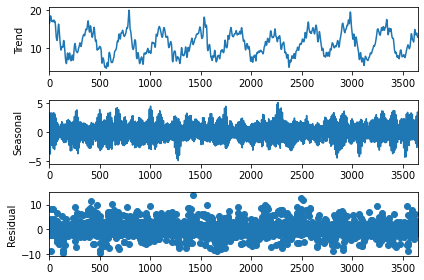

In [3]:
from statsmodels.tsa.seasonal import STL

series=data.values
stl = STL(series, period=12, robust=True)
res = stl.fit()
fig = res.plot(observed=False, resid=True)


In [4]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA

X = series.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]

In [5]:
# modelo auto-regresivo de orden 1
model = ARIMA(train, order=(1,0,0))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Prediction Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Expected: 13.000
Forecast: 14.687
Standard Error: 2.574
95% Prediction Interval: 9.643 to 19.732


In [6]:
# modelo media movil orden 1
model = ARIMA(train, order=(0,0,1))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Prediction Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Expected: 13.000
Forecast: 13.424
Standard Error: 3.071
95% Prediction Interval: 7.406 to 19.443


In [7]:
# modelo auto-regresivo orden 1 media movil orden 1
model = ARIMA(train, order=(1,0,1))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Prediction Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Expected: 13.000
Forecast: 14.472
Standard Error: 2.557
95% Prediction Interval: 9.461 to 19.483


In [8]:
# modelo auto-regresivo orden 1 integrado media movil orden 1 
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Prediction Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Expected: 13.000
Forecast: 14.781
Standard Error: 2.427
95% Prediction Interval: 10.024 to 19.538


para determinar el orden del modelo $AR(p)$, utilizamos la funcion de autocorrelacion parcial (PACF) la cual decae fuerte despues del orden $p$. 

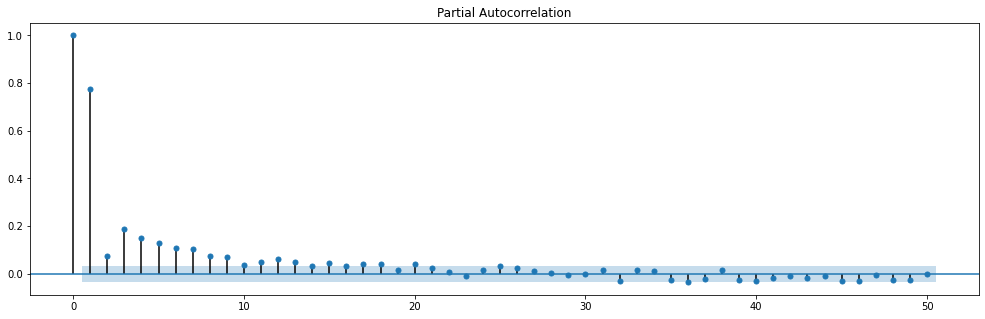

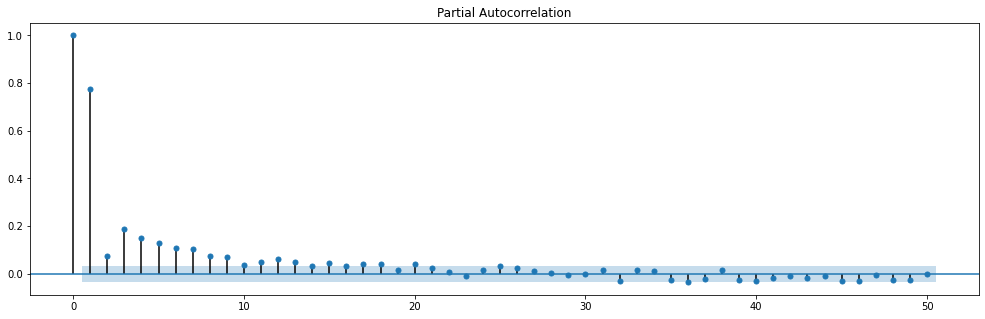

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(17,5))
plot_pacf(series, lags=50,ax=ax)

Para determinar el orden del modelo $MA(q)$, utilizamos la funcion de autocorrelacion (ACF) la cual decae fuerte despues del orden $q$. 

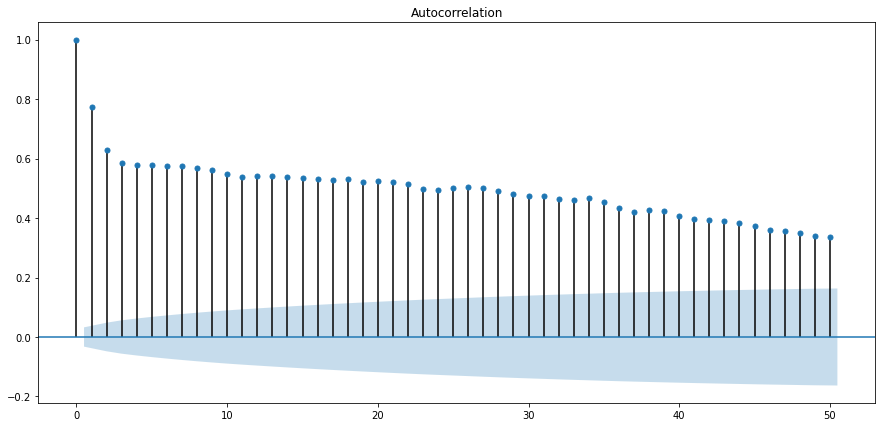

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(15,7))
plot_acf(series, lags=50,ax=ax)
plt.show()

In [11]:
# modelo AR orden 2  
model = ARIMA(train,order=(2,0,0))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Prediction Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Expected: 13.000
Forecast: 14.596
Standard Error: 2.566
95% Prediction Interval: 9.567 to 19.626


In [12]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 3649
Model:                     ARMA(2, 0)   Log Likelihood               -8616.924
Method:                       css-mle   S.D. of innovations              2.566
Date:                Fri, 14 Aug 2020   AIC                          17241.848
Time:                        18:21:45   BIC                          17266.657
Sample:                             0   HQIC                         17250.683
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1929      0.205     54.666      0.000      10.792      11.594
ar.L1.y        0.7157      0.017     43.347      0.000       0.683       0.748
ar.L2.y        0.0771      0.017      4.667      0.000       0.045       0.109
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2334           +0.0000j            1.2334            0.0000
AR.2          -10.5174           +0.0000j           10.5174            0.5000
-----------------------------------------------------------------------------
"""

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend= 'nc',disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print( 'ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f'%(best_cfg, best_score))

In [ ]:
import warnings

p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series, p_values, d_values, q_values)

(0, 0, 0)
(0, 0, 1)
ARIMA(0, 0, 1) RMSE=6.972
(0, 0, 2)
ARIMA(0, 0, 2) RMSE=5.104
(0, 0, 3)
ARIMA(0, 0, 3) RMSE=4.295
(0, 0, 4)
ARIMA(0, 0, 4) RMSE=3.856
(0, 1, 0)
(0, 1, 1)
ARIMA(0, 1, 1) RMSE=2.529
(0, 1, 2)
ARIMA(0, 1, 2) RMSE=2.346
(0, 1, 3)
ARIMA(0, 1, 3) RMSE=2.329
(0, 1, 4)
ARIMA(0, 1, 4) RMSE=2.331
(0, 2, 0)
(0, 2, 1)
ARIMA(0, 2, 1) RMSE=2.642
(0, 2, 2)
ARIMA(0, 2, 2) RMSE=2.530
(0, 2, 3)
ARIMA(0, 2, 3) RMSE=454425.862
(0, 2, 4)
ARIMA(0, 2, 4) RMSE=12.671
(1, 0, 0)
ARIMA(1, 0, 0) RMSE=2.627
(1, 0, 1)
(1, 0, 2)


# Tarea

En este laboratorio Ud debe completar las siguientes tareas:


1. Implementar un modelo ARIMA para predecir el total de 'casos por millon de habitantes'.
2. Reportar la metrica de ajuste del modelo base.
3. Reportar la metrica de ajuste del orden del modelo.


In [4]:
import pandas as pd

def get_owid_data(download=False):
    if download:
        data=pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
        data.to_csv('data/covid_owid_data.csv')
    else:
        data=pd.read_csv('data/covid_owid_data.csv')
    return data

data=get_owid_data(True)

In [5]:
data['date']=pd.to_datetime(data['date'],format='%Y/%m/%d')
data['location'] = data['location'].astype('category')
data['continent'] = data['continent'].astype('category')
data['iso_code'] = data['iso_code'].astype('category')

In [6]:
grouped_df=data.groupby(['location','date'],observed=True,sort=['date']).mean()
removed_outliers = grouped_df['new_cases_per_million']['Chile'].between(0, grouped_df['new_cases_per_million']['Chile'].quantile(.95))
data_chile=grouped_df['new_cases_per_million']['Chile'][removed_outliers]

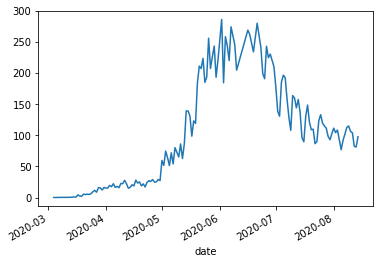

In [9]:
import matplotlib.pyplot as plt

data_chile.plot()
plt.show()